In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import numpy as np

import json
import gzip

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from network.model import NerFormer
from network.feature_network import FeatureNet
from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler

In [ ]:
from typing import Union, IO, Any, List, Tuple, Optional
import typing

In [3]:
frame_annotations_file = "test_dataset/frame_annotations.jgz"
frame_zipfile = gzip.open(frame_annotations_file, "rt", encoding="utf8")

frame_dicts = json.load(frame_zipfile)
print(type(frame_dicts), len(frame_dicts))

sequence_annotations_file = "test_dataset/test_sequence_annotations.jgz"
seq_zipfile = gzip.open(sequence_annotations_file, "rt", encoding="utf8")

seq_dicts = json.load(seq_zipfile)
print(type(seq_dicts), len(seq_dicts))

<class 'list'> 72865
<class 'list'> 749


In [4]:
# test dataset sequence : 5016
print(seq_dicts[13])

{'sequence_name': '38_1655_5016', 'category': 'teddybear', 'video': {'path': 'teddybear/38_1655_5016/video.MOV', 'length': -1.0}, 'point_cloud': {'path': 'teddybear/38_1655_5016/pointcloud.ply', 'quality_score': -0.1287639368068927, 'n_points': 107456}, 'viewpoint_quality_score': 1.5571424798893008}


In [5]:
# test dataset image : 1323 ~ 1332
data_dicts = frame_dicts[1323:1333]
print(data_dicts[0], '\n\n', data_dicts[-1])

print('\n\n', data_dicts[0].keys())
print('\n', data_dicts[0]['viewpoint'])

{'sequence_name': '38_1655_5016', 'frame_number': 0, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/38_1655_5016/images/frame000001.jpg', 'size': [479, 359]}, 'depth': {'path': 'teddybear/38_1655_5016/depths/frame000001.jpg.geometric.png', 'scale_adjustment': 1.262808918952942, 'mask_path': 'teddybear/38_1655_5016/depth_masks/frame000001.png'}, 'mask': {'path': 'teddybear/38_1655_5016/masks/frame000001.png', 'mass': 35984.0}, 'viewpoint': {'R': [[-0.9965706467628479, 0.004121924750506878, 0.08264364302158356], [-0.006493818014860153, -0.9995740652084351, -0.028452031314373016], [0.08249115943908691, -0.028891131281852722, 0.9961729049682617]], 'T': [0.20043912529945374, 1.2990046739578247, 6.429634094238281], 'focal_length': [2.1856130105871343, 1.6380690413377479], 'principal_point': [0.0, 0.0]}} 

 {'sequence_name': '38_1655_5016', 'frame_number': 9, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/38_1655_5016/images/frame000010.jpg', 'size': [480, 359]}, 'depth': {'path

(359, 479) (359, 480) (359, 480)


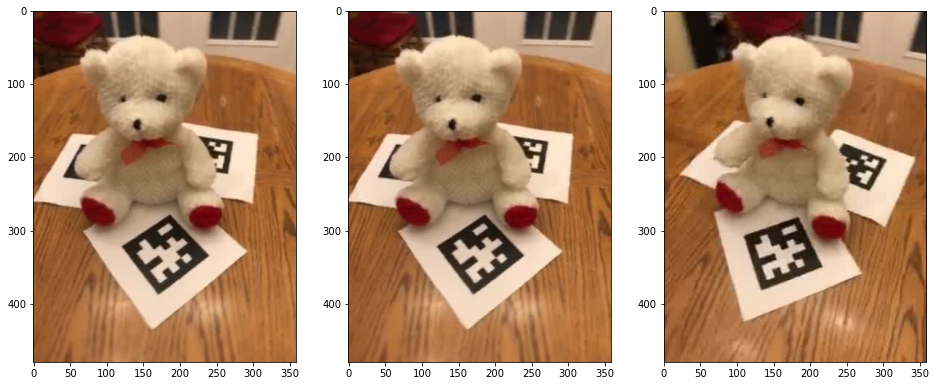

In [13]:
tgt_img = Image.open("test_dataset/frame000001.jpg")
src_img_1 = Image.open("test_dataset/frame000007.jpg")
src_img_2 = Image.open("test_dataset/frame000010.jpg")

print(tgt_img.size, src_img_1.size, src_img_2.size)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(src_img_1)
plt.subplot(1, 3, 2)
plt.imshow(src_img_1)
plt.subplot(1, 3, 3)
plt.imshow(src_img_2)

In [17]:
intrinsic = torch.eye(4)

viewpoint = data_dicts[0]['viewpoint']
intrinsic[0][0], intrinsic[1][1] = viewpoint['focal_length'][0], viewpoint['focal_length'][1]
intrinsic[0][2], intrinsic[1][2] = viewpoint['principal_point'][0], viewpoint['principal_point'][1]
intrinsic[2, 2] = 1

print("intrinsic : \n", intrinsic)

intrinsic : 
 tensor([[2.1856, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6381, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])


In [26]:
extrinsic = torch.eye(4)

rotation = torch.tensor(viewpoint['R'])
translation = torch.tensor(viewpoint['T'])

print("rotation matrix : \n", rotation, "\nshape : \n", rotation.shape)
print("------------\ntranslation matrix : \n", translation, "\nshape : \n", translation.shape)


extrinsic[:3, :3] = rotation
extrinsic[:3, 3] = translation

print("------------\nextrinsic : \n", extrinsic, "\nshape : \n", extrinsic.shape)

rotation matrix : 
 tensor([[-0.9966,  0.0041,  0.0826],
        [-0.0065, -0.9996, -0.0285],
        [ 0.0825, -0.0289,  0.9962]]) 
shape : 
 torch.Size([3, 3])
------------
translation matrix : 
 tensor([0.2004, 1.2990, 6.4296]) 
shape : 
 torch.Size([3])
------------
extrinsic : 
 tensor([[-9.9657e-01,  4.1219e-03,  8.2644e-02,  2.0044e-01],
        [-6.4938e-03, -9.9957e-01, -2.8452e-02,  1.2990e+00],
        [ 8.2491e-02, -2.8891e-02,  9.9617e-01,  6.4296e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]) 
shape : 
 torch.Size([4, 4])


In [27]:
c2w = torch.inverse(intrinsic.mul(extrinsic))

print("camera to world : \n", c2w, "\nshape : \n", c2w.shape)

camera to world : 
 tensor([[-0.4591,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.6107, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0038, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 
shape : 
 torch.Size([4, 4])


In [29]:
# (x, y, z) ---> 3(x, y, z) * 2(sin, cos) * 10 = 60으로 변환
pe = HarmonicEmbedding(10)

pe_test = pe(torch.tensor([0, 0, 1]))
print(pe_test)
print(pe_test.shape)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0998,  0.1987,  0.3894,  0.7174,
         0.9996, -0.0584,  0.1165,  0.2315,  0.4504,  0.8043,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.9950,  0.9801,  0.9211,  0.6967, -0.0292, -0.9983,
         0.9932,  0.9728,  0.8928,  0.5942])
torch.Size([60])


In [ ]:
ray_sampler = RaySampler(train_data, device)

In [ ]:
# 타겟 이미지 내에서 랜덤으로 픽셀 샘플링
def sample_random_pixel(H, W, N_rand, sample_mode, center_ratio=0.8):
    rng = np.random.RandomState(234)

    if sample_mode == 'center':
        border_H = int(H * (1 - center_ratio) / 2.)
        border_W = int(W * (1 - center_ratio) / 2.)

        # pixel coordinates
        u, v = np.meshgrid(np.arange(border_H, H - border_H),
                            np.arange(border_W, W - border_W))
        u = u.reshape(-1)
        v = v.reshape(-1)

        select_inds = rng.choice(u.shape[0], size=(N_rand,), replace=False)
        select_inds = v[select_inds] + W * u[select_inds]

    elif sample_mode == 'uniform':
        # Random from one image
        select_inds = rng.choice(H*W, size=(N_rand,), replace=False)
    else:
        raise Exception("unknown sample mode!")

    return select_inds

In [ ]:
random_pixels = sample_random_pixel(500, 500, 800, "center")
print(len(random_pixels), '\n', random_pixels[:10])

In [ ]:
# 타겟 이미지의 각 픽셀마다 rays_o, rays_d를 구함
def get_rays(H, W, intrinsics, c2w, batch_size=1, render_stride=1):
    '''
    param H: image height
    param W: image width
    param intrinsics: 4 by 4 intrinsic matrix
    param c2w: 4 by 4 camera to world extrinsic matrix
    
    return: rays_o, rays_d
    '''
    # u --> x 인덱싱
    # v --> y 인덱싱
    u, v = np.meshgrid(np.arange(W)[::render_stride], np.arange(H)[::render_stride])

    # 이미지의 각 row들이 이어붙은 형태로 변환
    # (H, W) --> (H*W)
    u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
    v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

    pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]
    pixels = torch.from_numpy(pixels)
    print(pixels.shape)
    batched_pixels = pixels.unsqueeze(0).repeat(batch_size, 1, 1)

    # bmm : batch matrix-matrix product 
    # [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
    rays_d = (c2w[:, :3, :3].bmm(torch.inverse(intrinsics[:, :3, :3])).bmm(batched_pixels)).transpose(1, 2)
    # rays_d = (c2w[:, :3, :3].bmm(torch.inverse(intrinsics[:, :3, :3])).bmm(pixels)).transpose(1, 2)
    rays_d = rays_d.reshape(-1, 3)
    rays_o = c2w[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)  # B x HW x 3
    
    return rays_o, rays_d

In [ ]:
rays_o, rays_d = get_rays(img1.height, img1.width, intrinsic.unsqueeze(0), c2w.unsqueeze(0))

print(rays_o.shape, rays_d.shape)

In [150]:
def sample_along_camera_ray(ray_o, ray_d, depth_range,
                            N_samples,
                            inv_uniform=False,
                            det=False):
    '''
    param ray_o: scene coordinate system에서 ray의 원점 : [N_rays, 3]
    param ray_d: scene coordinate system에서 ray의 direction vector : [N_rays, 3]
    param depth_range: [near_depth, far_depth]
    param inv_uniform: if True, uniformly sampling inverse depth
    param det: if True, will perform deterministic sampling
    
    return: tensor of shape [N_rays, N_samples, 3]
    '''
    # 샘플들은 [near_depth, far_depth] 범위 안에 있어야 함.
    # assume the nearest possible depth is at least (min_ratio * depth)
    near_depth_value = depth_range[0, 0]
    far_depth_value = depth_range[0, 1]
    assert near_depth_value > 0 and far_depth_value > 0 and far_depth_value > near_depth_value

    near_depth = near_depth_value * torch.ones_like(ray_d[..., 0])
    far_depth = far_depth_value * torch.ones_like(ray_d[..., 0])

    if inv_uniform:
        start = 1. / near_depth     # [N_rays,]
        step = (1. / far_depth - start) / (N_samples-1)
        inv_z_vals = torch.stack([start+i*step for i in range(N_samples)], dim=1)  # [N_rays, N_samples]
        z_vals = 1. / inv_z_vals
    else:
        start = near_depth
        step = (far_depth - near_depth) / (N_samples-1)
        z_vals = torch.stack([start+i*step for i in range(N_samples)], dim=1)  # [N_rays, N_samples]

    if not det:
        # get intervals between samples
        mids = .5 * (z_vals[:, 1:] + z_vals[:, :-1])
        upper = torch.cat([mids, z_vals[:, -1:]], dim=-1)
        lower = torch.cat([z_vals[:, 0:1], mids], dim=-1)
        # uniform samples in those intervals
        t_rand = torch.rand_like(z_vals)
        z_vals = lower + (upper - lower) * t_rand   # [N_rays, N_samples]

    ray_d = ray_d.unsqueeze(1).repeat(1, N_samples, 1)  # [N_rays, N_samples, 3]
    ray_o = ray_o.unsqueeze(1).repeat(1, N_samples, 1)

    # 샘플 포인트 위치를 계산.
    # ray의 원점으로부터 ray의 방향으로 z_val만큼 전진한 것.
    pts = z_vals.unsqueeze(2) * ray_d + ray_o       # [N_rays, N_samples, 3]
    
    return pts, z_vals

In [145]:
ray_d = rays_d.clone()
ray_o = rays_o.clone()

print(ray_d.shape, ray_o.shape)

torch.Size([171961, 3]) torch.Size([171961, 3])


In [154]:
depth_range = torch.tensor([[0.1, 3.0]])
N_samples = 20

pts, z_vals = sample_along_camera_ray(ray_o, ray_d, depth_range, N_samples)

In [155]:
print(pts.shape)
print(z_vals.shape)

torch.Size([171961, 20, 3])
torch.Size([171961, 20])


In [159]:
# 400번째 ray에서의 samples
pts[400]

tensor([[ -1.4153,  -0.0613,   0.1650],
        [ -1.5882,  -0.0688,   0.1851],
        [ -3.4004,  -0.1472,   0.3963],
        [ -5.2240,  -0.2261,   0.6089],
        [ -6.6318,  -0.2871,   0.7730],
        [ -7.8613,  -0.3403,   0.9163],
        [ -8.7938,  -0.3807,   1.0250],
        [-10.1739,  -0.4404,   1.1858],
        [-10.7546,  -0.4656,   1.2535],
        [-12.8424,  -0.5560,   1.4969],
        [-13.9064,  -0.6020,   1.6209],
        [-15.5691,  -0.6740,   1.8147],
        [-16.1829,  -0.7006,   1.8862],
        [-17.7843,  -0.7699,   2.0729],
        [-18.9395,  -0.8199,   2.2075],
        [-20.2334,  -0.8759,   2.3583],
        [-21.3119,  -0.9226,   2.4840],
        [-22.5580,  -0.9765,   2.6293],
        [-24.7361,  -1.0708,   2.8831],
        [-25.7066,  -1.1128,   2.9963]])